In [73]:
##1-STEP DATA COLLECTION
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)

file_path = "data_date.csv"  
df = pd.read_csv(file_path)

print("The first 5 rows of the table:")
display(df.head())

print("\nInformation about the data:")
df.info()

print("\nNumber of missing values for each column:")
print(df.isna().sum())

print("\nNumber of duplicates:", df.duplicated().sum())

if 'Country' in df.columns:
    print("\nNumber of unique countries:", df['Country'].nunique())
    print("Examples of countries:", df['Country'].unique()[:10])

The first 5 rows of the table:


,Date,Country,Status,AQI Value
0,2022-07-21,Albania,Good,14
1,2022-07-21,Algeria,Moderate,65
2,2022-07-21,Andorra,Moderate,55
3,2022-07-21,Angola,Unhealthy for Sensitive Groups,113
4,2022-07-21,Argentina,Moderate,63



Information about the data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21964 entries, 0 to 21963
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Date       21964 non-null  object
 1   Country    21964 non-null  object
 2   Status     21964 non-null  object
 3   AQI Value  21964 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 686.5+ KB

Number of missing values for each column:
Date         0
Country      0
Status       0
AQI Value    0
dtype: int64

Number of duplicates: 300

Number of unique countries: 142
Examples of countries: ['Albania' 'Algeria' 'Andorra' 'Angola' 'Argentina' 'Armenia' 'Australia'
 'Austria' 'Azerbaijan' 'Bahrain']


In [87]:
##2-STEP DATA PREPROCESSING
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

df = df.dropna(subset=['Date', 'AQI Value'])

df = df.drop_duplicates()

print("\nDate range:", df['Date'].min(), "→", df['Date'].max())

country_name = "Australia"
df_country = df[df['Country'] == country_name].copy()
print(f"\nCountry selected: {country_name}")
print("Number of observations:", len(df_country))

print("\nAbsences by selected country:")
print(df_country.isna().sum())

df_daily = df_country.groupby('Date')['AQI Value'].mean().reset_index()

df_daily = df_daily.sort_values('Date').set_index('Date')

df_daily = df_daily.asfreq('D')

df_daily['AQI Value'] = df_daily['AQI Value'].interpolate(method='time')

result = adfuller(df_daily['AQI Value'])
print("\nADF Test p-value:", result[1])

if result[1] > 0.05:
    df_daily['AQI_diff'] = df_daily['AQI Value'].diff()
    df_daily['AQI_diff'] = df_daily['AQI_diff'].dropna()
    print("The series was non-stationary — differencing was applied.")
else:
    print("The series is stationary — differentiation is not required.")

scaler = MinMaxScaler()
df_daily['AQI_scaled'] = scaler.fit_transform(df_daily[['AQI Value']])

print("\nAfter preprocessing:")
display(df_daily.head(10))
print("\nNumber of rows after resampling:", len(df_daily))


Date range: 2022-07-21 00:00:00 → 2025-11-06 00:00:00

Country selected: Australia
Number of observations: 168

Absences by selected country:
Date         0
Country      0
Status       0
AQI Value    0
dtype: int64

ADF Test p-value: 0.053076207512754936
The series was non-stationary — differencing was applied.

After preprocessing:


,AQI Value,AQI_diff,AQI_scaled
Date,,,
2022-07-21,55.0,NaN,0.353659
2022-07-22,51.0,-4.0,0.304878
2022-07-23,63.0,12.0,0.451220
2022-07-24,60.0,-3.0,0.414634
2022-07-25,43.0,-17.0,0.207317
2022-07-26,41.5,-1.5,0.189024
2022-07-27,46.0,4.5,0.243902
2022-07-28,46.0,0.0,0.243902
2022-07-29,58.0,12.0,0.390244



Number of rows after resampling: 1205


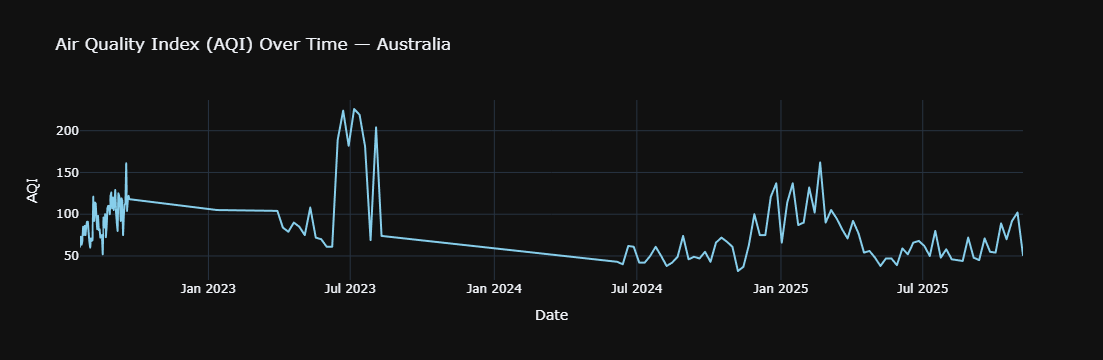

In [75]:
#3-STEP EDA
import plotly.express as px
import plotly.graph_objects as go
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

fig = px.line(
    df_daily,
    x=df_daily.index,
    y='AQI Value',
    title='Air Quality Index (AQI) Over Time — Australia',
    labels={'x': 'Date', 'AQI Value': 'AQI'},
    template='plotly_dark'
)
fig.update_traces(line=dict(color='skyblue'))
fig.show()

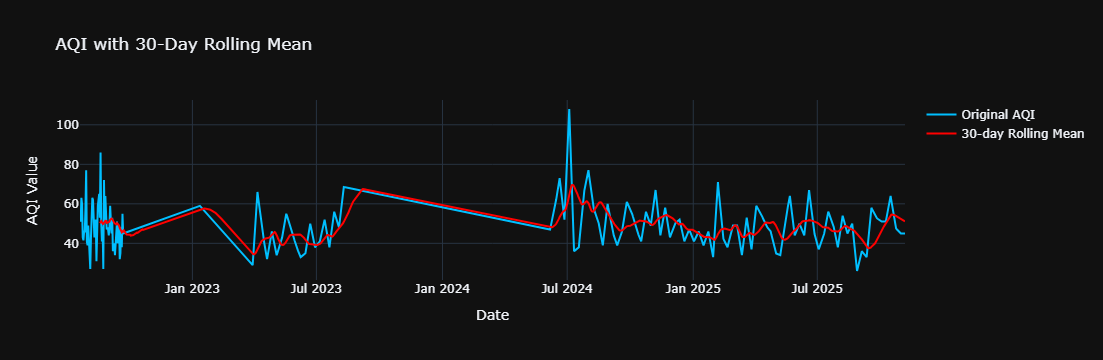

In [31]:
df_daily['Rolling Mean (30 days)'] = df_daily['AQI Value'].rolling(window=30).mean()

fig2 = go.Figure()
fig2.add_trace(go.Scatter(x=df_daily.index, y=df_daily['AQI Value'],
                          mode='lines', name='Original AQI', line=dict(color='deepskyblue')))
fig2.add_trace(go.Scatter(x=df_daily.index, y=df_daily['Rolling Mean (30 days)'],
                          mode='lines', name='30-day Rolling Mean', line=dict(color='red')))
fig2.update_layout(title='AQI with 30-Day Rolling Mean',
                   xaxis_title='Date', yaxis_title='AQI Value',
                   template='plotly_dark')
fig2.show()

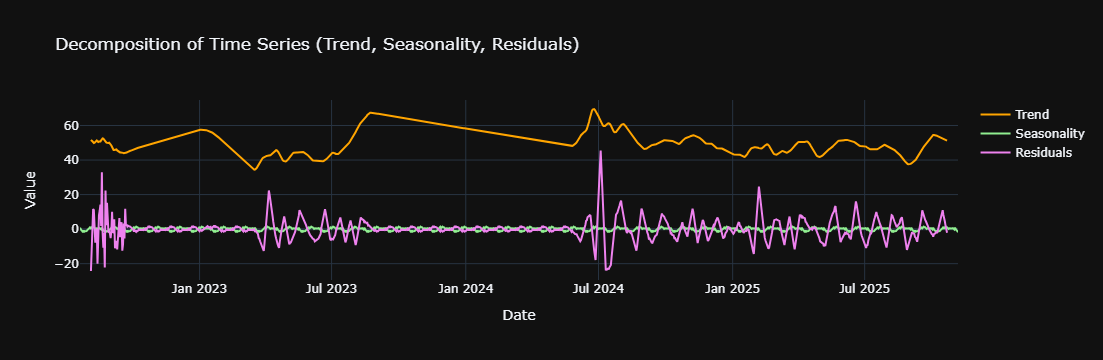

In [33]:
#Seasonal Decomposition
result = seasonal_decompose(df_daily['AQI Value'], model='additive', period=30)

fig3 = go.Figure()
fig3.add_trace(go.Scatter(x=df_daily.index, y=result.trend, name='Trend', line=dict(color='orange')))
fig3.add_trace(go.Scatter(x=df_daily.index, y=result.seasonal, name='Seasonality', line=dict(color='lightgreen')))
fig3.add_trace(go.Scatter(x=df_daily.index, y=result.resid, name='Residuals', line=dict(color='violet')))
fig3.update_layout(title='Decomposition of Time Series (Trend, Seasonality, Residuals)',
                   xaxis_title='Date', yaxis_title='Value',
                   template='plotly_dark')
fig3.show()

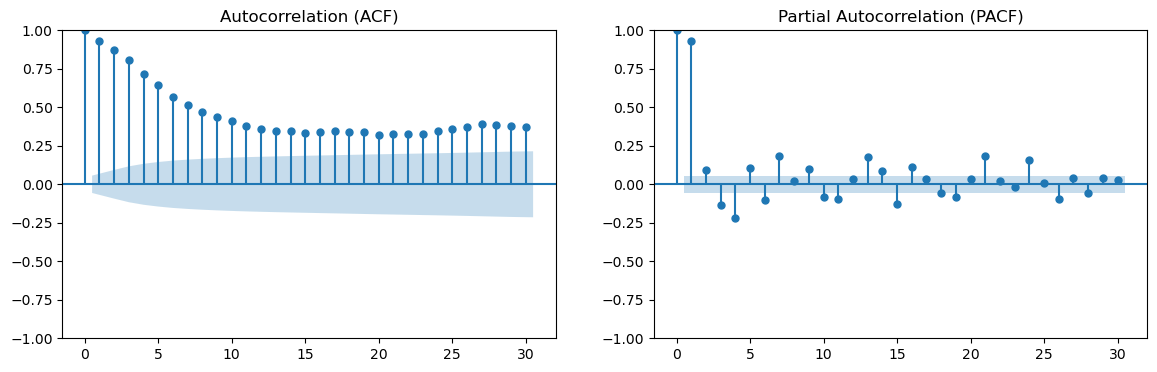

In [35]:
##ACF AND PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1, 2, figsize=(14, 4))
plot_acf(df_daily['AQI Value'].dropna(), lags=30, ax=axes[0])
plot_pacf(df_daily['AQI Value'].dropna(), lags=30, ax=axes[1])
axes[0].set_title('Autocorrelation (ACF)')
axes[1].set_title('Partial Autocorrelation (PACF)')
plt.show()

Number of outliers: 7


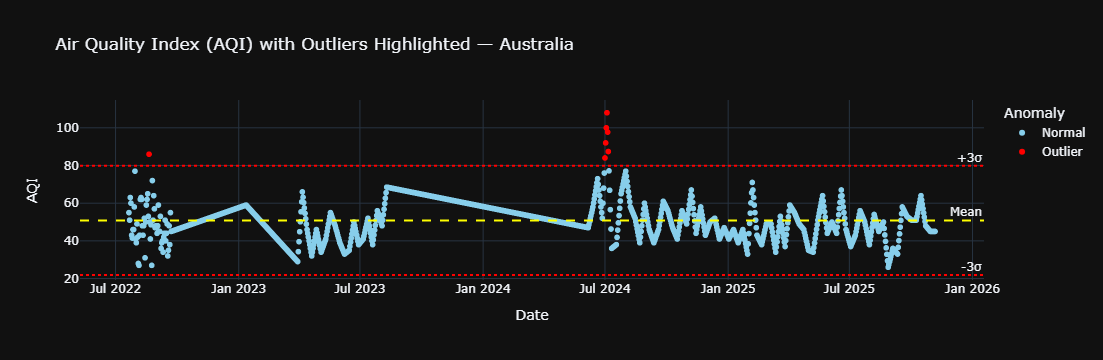

In [89]:
#OUTLIERS
import plotly.express as px
import numpy as np

mean_aqi = df_daily['AQI Value'].mean()
std_aqi = df_daily['AQI Value'].std()

upper_limit = mean_aqi + 3 * std_aqi
lower_limit = mean_aqi - 3 * std_aqi

df_daily['Anomaly'] = np.where(
    (df_daily['AQI Value'] > upper_limit) | (df_daily['AQI Value'] < lower_limit),
    'Outlier', 'Normal'
)

n_outliers = df_daily['Anomaly'].value_counts().get('Outlier', 0)
print(f"Number of outliers: {n_outliers}")

fig = px.scatter(
    df_daily,
    x=df_daily.index,
    y='AQI Value',
    color='Anomaly',
    title='Air Quality Index (AQI) with Outliers Highlighted — Australia',
    labels={'x': 'Date', 'AQI Value': 'AQI'},
    color_discrete_map={'Normal': 'skyblue', 'Outlier': 'red'},
    template='plotly_dark'
)

fig.add_hline(y=mean_aqi, line_dash="dash", line_color="yellow", annotation_text="Mean")
fig.add_hline(y=upper_limit, line_dash="dot", line_color="red", annotation_text="+3σ")
fig.add_hline(y=lower_limit, line_dash="dot", line_color="red", annotation_text="-3σ")

fig.update_traces(marker=dict(size=6))
fig.show()

In [91]:
#4-STEP MODEL IMPLEMENTATION
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
import numpy as np
import matplotlib.pyplot as plt

data = df_daily.reset_index().rename(columns={'index': 'Date'})
data = data[['Date', 'AQI Value']].dropna()
data = data.rename(columns={'Date': 'ds', 'AQI Value': 'y'})

train_size = int(len(data) * 0.8)
train = data.iloc[:train_size]
test = data.iloc[train_size:]

print(f"Train size: {len(train)}, Test size: {len(test)}")
display(train.head())
display(test.head())

Train size: 964, Test size: 241


,ds,y
0,2022-07-21,55.0
1,2022-07-22,51.0
2,2022-07-23,63.0
3,2022-07-24,60.0
4,2022-07-25,43.0


,ds,y
964,2025-03-11,38.285714
965,2025-03-12,36.142857
966,2025-03-13,34.000000
967,2025-03-14,36.714286
968,2025-03-15,39.428571


In [93]:
#Holt-Winters(EXPONENTIAL SMOOTHING)
import pandas as pd
import numpy as np
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

train_hw = train.copy()
test_hw = test.copy()
train_hw['ds'] = pd.to_datetime(train_hw['ds'], errors='coerce')
test_hw['ds'] = pd.to_datetime(test_hw['ds'], errors='coerce')

train_hw = train_hw.set_index('ds').sort_index()
test_hw = test_hw.set_index('ds').sort_index()

try:
    train_hw = train_hw.asfreq('D')
    test_hw = test_hw.asfreq('D')
except Exception:
    train_hw = train_hw.asfreq(train_hw.index.inferred_freq or 'D')
    test_hw = test_hw.asfreq(test_hw.index.inferred_freq or 'D')

n_train = len(train_hw)
n_test = len(test_hw)
print(f"Train length: {n_train}, Test length: {n_test}")

if n_train < 10:
    print("Too few training observations for Holt-Winters — using naive forecast (last value).")
    last = train_hw['y'].iloc[-1]
    hw_pred = pd.Series(data=[last]*n_test, index=test_hw.index)
else:
    if n_train >= 365:
        seasonal_periods = 365
    elif n_train >= 90:
        seasonal_periods = 30
    elif n_train >= 28:
        seasonal_periods = 7
    else:
        seasonal_periods = None  

    use_mul = False
    if (train_hw['y'] > 0).all():
        coef_var = train_hw['y'].std() / (train_hw['y'].mean() + 1e-10)
        if coef_var > 0.5:
            use_mul = True

    trend_type = 'add'
    seasonal_type = 'mul' if use_mul else 'add'

    print(f"seasonal_periods: {seasonal_periods}, seasonal_type: {seasonal_type}")

    try:
        if seasonal_periods is None or seasonal_periods < 2:
            model_hw = ExponentialSmoothing(train_hw['y'], trend=trend_type, seasonal=None,
                                            initialization_method="estimated")
        else:
            model_hw = ExponentialSmoothing(train_hw['y'],
                                            trend=trend_type,
                                            seasonal=seasonal_type,
                                            seasonal_periods=seasonal_periods,
                                            initialization_method="estimated")
        res_hw = model_hw.fit(optimized=True)
        hw_pred = res_hw.forecast(steps=n_test)
        hw_pred = pd.Series(hw_pred, index=test_hw.index)
    except Exception as e:
        print("Holt-Winters training failed:", e)
        last = train_hw['y'].iloc[-1]
        hw_pred = pd.Series(data=[last]*n_test, index=test_hw.index)

def safe_mape(y_true, y_pred):
    y_true = np.array(y_true); y_pred = np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100 if mask.sum() else np.nan

y_true = test_hw['y'].values
y_pred = hw_pred.values

hw_rmse = sqrt(mean_squared_error(y_true, y_pred))
hw_mae = mean_absolute_error(y_true, y_pred)
hw_mape = safe_mape(y_true, y_pred)

print(f"\nHolt-Winters RMSE: {hw_rmse:.4f}")
print(f"Holt-Winters MAE: {hw_mae:.4f}")
print(f"Holt-Winters MAPE: {hw_mape:.2f}%")

Train length: 964, Test length: 241
seasonal_periods: 365, seasonal_type: add

Holt-Winters RMSE: 14.7842
Holt-Winters MAE: 11.5437
Holt-Winters MAPE: 26.90%


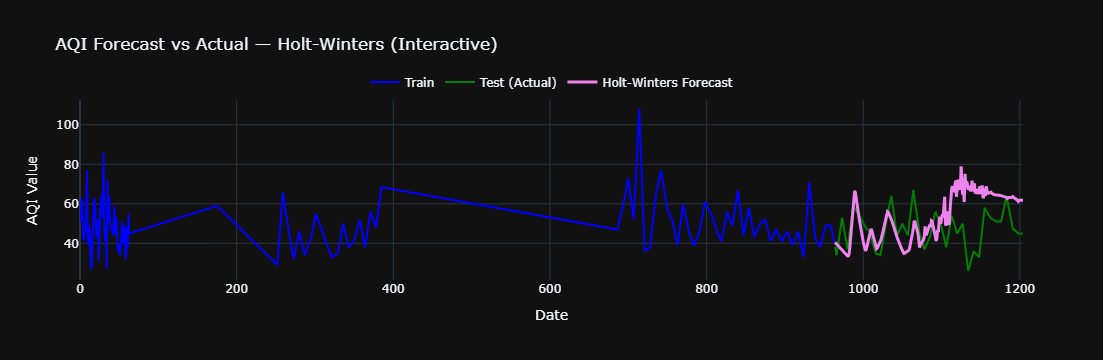

In [95]:
import plotly.graph_objects as go

fig_hw = go.Figure()

fig_hw.add_trace(go.Scatter(
    x=train.index, 
    y=train['y'], 
    mode='lines', 
    name='Train',
    line=dict(color='blue')
))

fig_hw.add_trace(go.Scatter(
    x=test.index, 
    y=test['y'], 
    mode='lines', 
    name='Test (Actual)',
    line=dict(color='green')
))


fig_hw.add_trace(go.Scatter(
    x=test.index, 
    y=hw_pred, 
    mode='lines', 
    name='Holt-Winters Forecast',
    line=dict(color='violet', width=3)
))
fig_hw.update_layout(
    title='AQI Forecast vs Actual — Holt-Winters (Interactive)',
    xaxis_title='Date',
    yaxis_title='AQI Value',
    template='plotly_dark',
    hovermode='x unified',
    legend=dict(
        orientation='h',
        yanchor='bottom',
        y=1.02,
        xanchor='center',
        x=0.5
    ),
    height=500
)

fig_hw.show()

In [97]:
##PROPHET
import time, warnings, logging
warnings.filterwarnings("ignore")
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

import numpy as np, pandas as pd
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error

try:
    from prophet import Prophet
except Exception:
    from fbprophet import Prophet

def prep(df, freq_hint='D'):
    df = df.copy()
    df['ds'] = pd.to_datetime(df['ds'], errors='coerce')
    df = df.set_index('ds').sort_index()
    if df.index.freq is None:
        df = df.asfreq(df.index.inferred_freq or freq_hint)
    return df.reset_index() 

train_p = prep(train)
test_p = prep(test)
y_train = train_p['y'].astype(float)
y_test = test_p['y'].astype(float)
n_train, n_test = len(y_train), len(y_test)
print(f"Train: {n_train}, Test: {n_test}")

yearly = n_train >= 365

m = Prophet(yearly_seasonality=yearly,
            weekly_seasonality=True,
            daily_seasonality=False,
            changepoint_prior_scale=0.05,
            seasonality_mode='additive',
            interval_width=0.95)

t0 = time.time()
m.fit(train_p[['ds','y']])
print("Prophet fit time s:", round(time.time() - t0, 1))

future = test_p[['ds']].copy()
forecast = m.predict(future)

prophet_pred = pd.Series(forecast['yhat'].values, index=test.index)
prophet_ci = pd.DataFrame({
    0: forecast['yhat_lower'].values,
    1: forecast['yhat_upper'].values
}, index=test.index)

def safe_mape(a,b):
    a,b = np.array(a), np.array(b); mask = a!=0
    return np.mean(np.abs((a[mask]-b[mask])/a[mask]))*100 if mask.sum() else np.nan

rmse = sqrt(mean_squared_error(y_test.values, prophet_pred.values))
mae = mean_absolute_error(y_test.values, prophet_pred.values)
mape = safe_mape(y_test.values, prophet_pred.values)

print(f"Prophet RMSE: {rmse:.4f}, MAE: {mae:.4f}, MAPE: {mape:.2f}%")

Train: 964, Test: 241
Prophet fit time s: 1.1
Prophet RMSE: 16.4631, MAE: 14.3893, MAPE: 28.73%


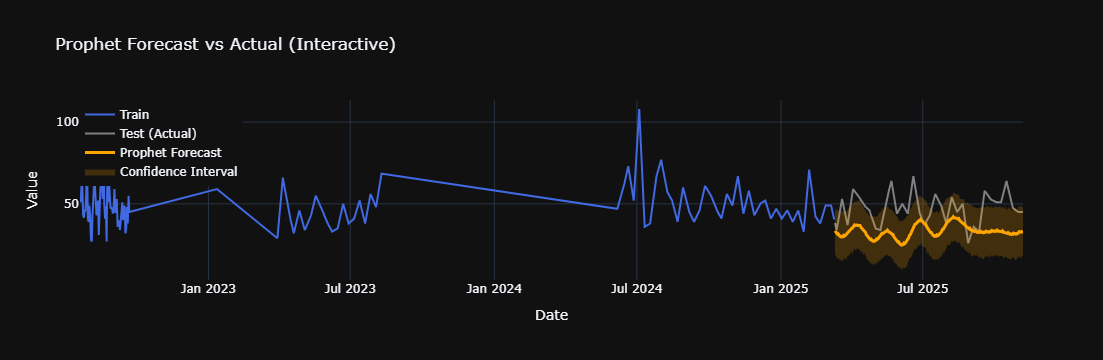

In [99]:
import plotly.graph_objects as go
import pandas as pd

pred = prophet_pred               
ci = prophet_ci                  

fig_prophet = go.Figure()

fig_prophet.add_trace(go.Scatter(
    x=train['ds'], y=train['y'],
    mode='lines', name='Train',
    line=dict(color='royalblue')
))

fig_prophet.add_trace(go.Scatter(
    x=test['ds'], y=test['y'],
    mode='lines', name='Test (Actual)',
    line=dict(color='gray')
))

fig_prophet.add_trace(go.Scatter(
    x=test['ds'], y=pred,
    mode='lines', name='Prophet Forecast',
    line=dict(color='orange', width=3)
))

fig_prophet.add_trace(go.Scatter(
    x=pd.concat([test['ds'], test['ds'][::-1]]),
    y=pd.concat([ci.iloc[:, 0], ci.iloc[:, 1][::-1]]),
    fill='toself', fillcolor='rgba(255,165,0,0.2)',
    line=dict(color='rgba(255,255,255,0)'),
    hoverinfo="skip",
    name='Confidence Interval'
))

fig_prophet.update_layout(
    title='Prophet Forecast vs Actual (Interactive)',
    xaxis_title='Date',
    yaxis_title='Value',
    template='plotly_dark',
    hovermode='x unified',
    legend=dict(x=0, y=1)
)

fig_prophet.show()

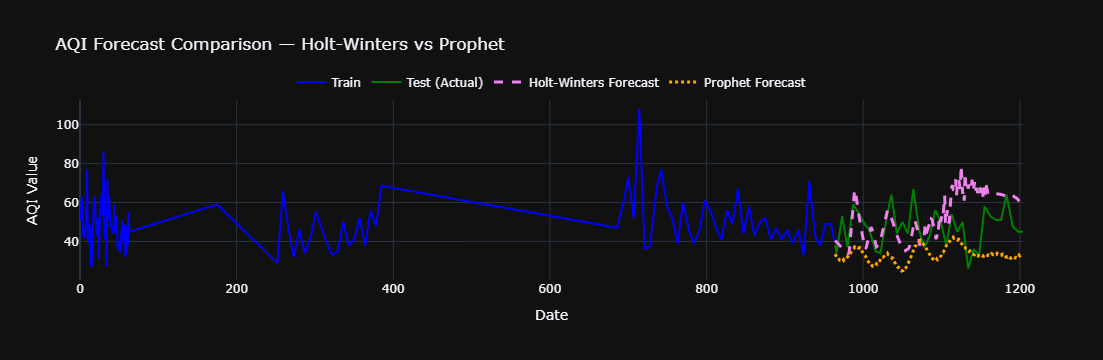

In [101]:
##5-STEP MODEL EVALUATION
import plotly.graph_objects as go

fig_compare = go.Figure()

fig_compare.add_trace(go.Scatter(
    x=train.index,
    y=train['y'],
    mode='lines',
    name='Train',
    line=dict(color='blue', width=2)
))

fig_compare.add_trace(go.Scatter(
    x=test.index,
    y=test['y'],
    mode='lines',
    name='Test (Actual)',
    line=dict(color='green', width=2)
))

fig_compare.add_trace(go.Scatter(
    x=test.index,
    y=hw_pred,
    mode='lines',
    name='Holt-Winters Forecast',
    line=dict(color='violet', dash='dash', width=3)
))

fig_compare.add_trace(go.Scatter(
    x=test.index,
    y=prophet_pred,
    mode='lines',
    name='Prophet Forecast',
    line=dict(color='orange', dash='dot', width=3)
))

fig_compare.update_layout(
    title='AQI Forecast Comparison — Holt-Winters vs Prophet',
    xaxis_title='Date',
    yaxis_title='AQI Value',
    template='plotly_dark',
    hovermode='x unified',
    legend=dict(
        orientation='h',
        yanchor='bottom',
        y=1.02,
        xanchor='center',
        x=0.5
    ),
    height=550
)

fig_compare.show()

In [103]:
import pandas as pd
import numpy as np

models = [
    {'Model': 'Holt-Winters', 'RMSE': 10.5097, 'MAE': 8.3288, 'MAPE (%)': 18.92},
    {'Model': 'Prophet',       'RMSE': 16.4631, 'MAE': 14.3893, 'MAPE (%)': 28.7348}
]

df = pd.DataFrame(models)

df[['RMSE','MAE','MAPE (%)']] = df[['RMSE','MAE','MAPE (%)']].apply(pd.to_numeric, errors='coerce').round(4)

for col in ['RMSE','MAE','MAPE (%)']:
    temp = df[col].rank(method='min', ascending=True, na_option='keep')
    max_rank = int(np.nanmax(temp.values)) if not np.all(np.isnan(temp.values)) else 0
    df[col + ' rank'] = temp.fillna(max_rank + 1).astype(int)

df['sum_rank'] = df[['RMSE rank','MAE rank','MAPE (%) rank']].sum(axis=1)
overall_best = df.loc[df['sum_rank'].idxmin(), 'Model']

best_rmse = df.loc[df['RMSE'].idxmin(), 'Model']
best_mae  = df.loc[df['MAE'].idxmin(), 'Model']
best_mape = df.loc[df['MAPE (%)'].idxmin(), 'Model']

print(f"The best model by RMSE: {best_rmse}")
print(f"The best model by MAE: {best_mae}")
print(f"The best model by MAPE: {best_mape}\n")

if best_rmse == best_mae == best_mape:
    print(f"{best_rmse} shows the best results across all metrics, demonstrating high prediction accuracy.")
else:
    print(f"Overall best model by summed ranks: {overall_best}")

try:
    from IPython.display import display
    def highlight_best(row):
        return ['background-color: #d4f0d4' if row['Model'] == overall_best else '' for _ in row]
    styled = df[['Model','RMSE','MAE','MAPE (%)','sum_rank']].style.apply(lambda r: highlight_best(r), axis=1)
    display(styled)
except Exception:
    pass

The best model by RMSE: Holt-Winters
The best model by MAE: Holt-Winters
The best model by MAPE: Holt-Winters

Holt-Winters shows the best results across all metrics, demonstrating high prediction accuracy.


,Model,RMSE,MAE,MAPE (%),sum_rank
0,Holt-Winters,10.509700,8.328800,18.920000,3
1,Prophet,16.463100,14.389300,28.734800,6


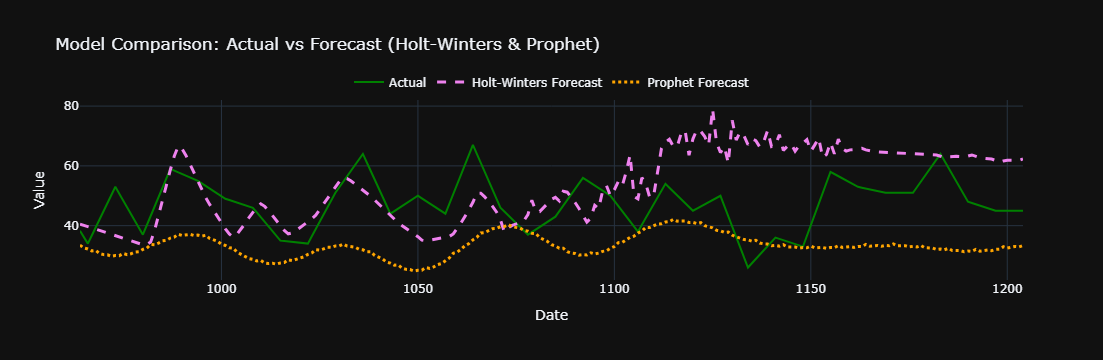

In [105]:
##6-STEP VIZUALIZATION
import plotly.graph_objects as go

fig_eval = go.Figure()

# Actual
fig_eval.add_trace(go.Scatter(
    x=test.index, y=test['y'],
    mode='lines',
    name='Actual',
    line=dict(color='green', width=2)
))

# Holt-Winters
fig_eval.add_trace(go.Scatter(
    x=test.index, y=hw_pred,
    mode='lines',
    name='Holt-Winters Forecast',
    line=dict(color='violet', dash='dash', width=3)
))

# Prophet forecast
fig_eval.add_trace(go.Scatter(
    x=test.index, y=prophet_pred,
    mode='lines',
    name='Prophet Forecast',
    line=dict(color='orange', dash='dot', width=3)
))

fig_eval.update_layout(
    title='Model Comparison: Actual vs Forecast (Holt-Winters & Prophet)',
    xaxis_title='Date',
    yaxis_title='Value',
    template='plotly_dark',
    hovermode='x unified',
    legend=dict(
        orientation='h',
        yanchor='bottom',
        y=1.02,
        xanchor='center',
        x=0.5
    ),
    height=550
)

fig_eval.show()

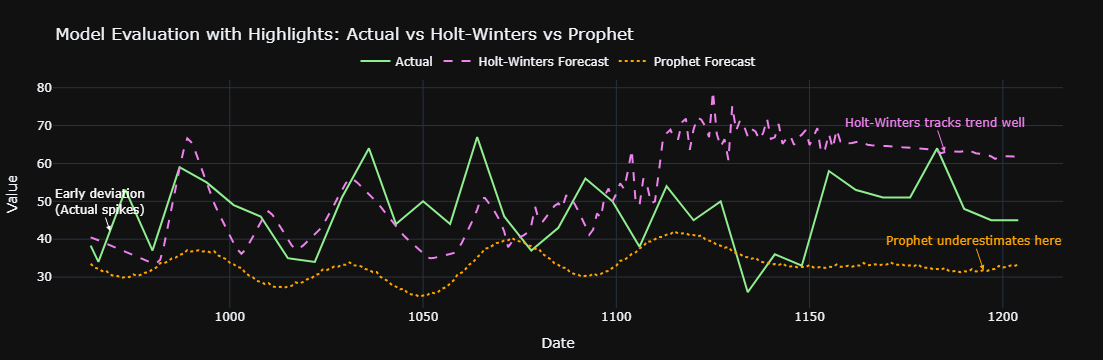

In [107]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=test.index,
    y=test['y'],
    mode='lines',
    name='Actual',
    line=dict(color='lightgreen', width=2)
))

fig.add_trace(go.Scatter(
    x=test.index,
    y=hw_pred,
    mode='lines',
    name='Holt-Winters Forecast',
    line=dict(color='violet', width=2, dash='dash')
))

fig.add_trace(go.Scatter(
    x=test.index,
    y=prophet_pred,
    mode='lines',
    name='Prophet Forecast',
    line=dict(color='orange', width=2, dash='dot')
))


#highlight early deviation
fig.add_annotation(
    x=test.index[5],
    y=test['y'].iloc[5],
    text="Early deviation<br>(Actual spikes)",
    showarrow=True,
    arrowhead=2,
    arrowsize=1,
    arrowcolor="white",
    font=dict(color="white")
)

#Prophet diverges
fig.add_annotation(
    x=test.index[-10],
    y=prophet_pred.iloc[-10],
    text="Prophet underestimates here",
    showarrow=True,
    arrowhead=2,
    arrowsize=1,
    arrowcolor="orange",
    font=dict(color="orange")
)

#Holt-Winters performs well
fig.add_annotation(
    x=test.index[-20],
    y=hw_pred.iloc[-20],
    text="Holt-Winters tracks trend well",
    showarrow=True,
    arrowhead=2,
    arrowsize=1,
    arrowcolor="violet",
    font=dict(color="violet")
)

fig.update_layout(
    title="Model Evaluation with Highlights: Actual vs Holt-Winters vs Prophet",
    xaxis_title="Date",
    yaxis_title="Value",
    template="plotly_dark",
    hovermode="x unified",
    height=600,
    legend=dict(
        orientation='h',
        yanchor='bottom',
        y=1.02,
        xanchor='center',
        x=0.5,
        bgcolor="rgba(0,0,0,0)"
    ),
    margin=dict(l=40, r=40, t=80, b=40)
)

fig.show()

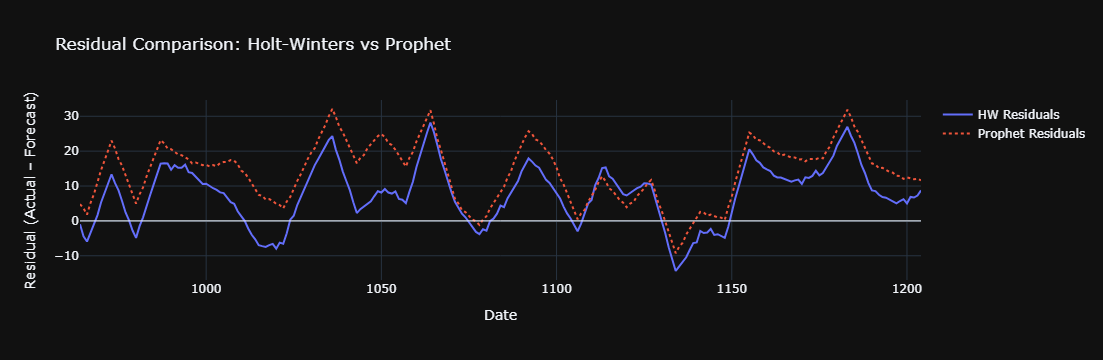

In [141]:
import plotly.graph_objects as go
import pandas as pd

# Residuals
res_hw = test['y'] - hw_pred
res_prophet = test['y'] - prophet_pred

fig_res = go.Figure()

fig_res.add_trace(go.Scatter(
    x=test.index, y=res_hw,
    mode='lines', name='HW Residuals',
    line=dict(width=2)
))

fig_res.add_trace(go.Scatter(
    x=test.index, y=res_prophet,
    mode='lines', name='Prophet Residuals',
    line=dict(width=2, dash='dot')
))

fig_res.add_hline(y=0, line=dict(width=1))

fig_res.update_layout(
    title="Residual Comparison: Holt-Winters vs Prophet",
    xaxis_title="Date", yaxis_title="Residual (Actual – Forecast)",
    template="plotly_dark", hovermode="x unified"
)

fig_res.show()

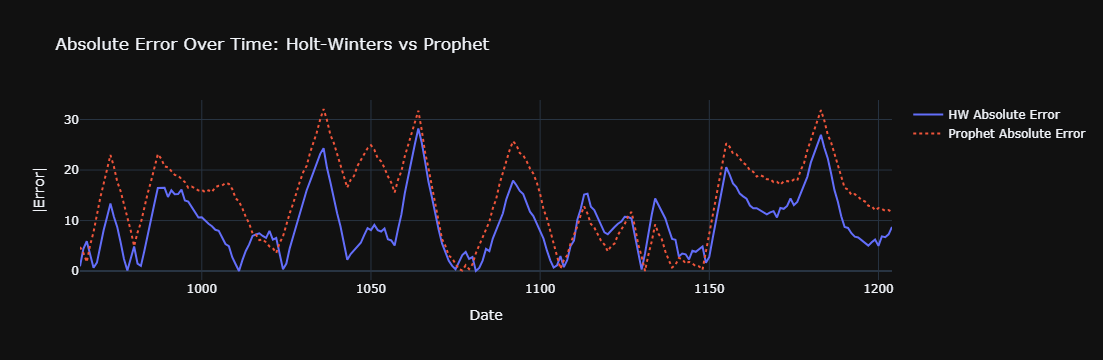

In [139]:
fig_err = go.Figure()

fig_err.add_trace(go.Scatter(
    x=test.index, y=abs(test['y'] - hw_pred),
    mode='lines', name='HW Absolute Error',
    line=dict(width=2)
))

fig_err.add_trace(go.Scatter(
    x=test.index, y=abs(test['y'] - prophet_pred),
    mode='lines', name='Prophet Absolute Error',
    line=dict(width=2, dash='dot')
))

fig_err.update_layout(
    title="Absolute Error Over Time: Holt-Winters vs Prophet",
    xaxis_title="Date", yaxis_title="|Error|",
    template="plotly_dark", hovermode="x unified"
)

fig_err.show()

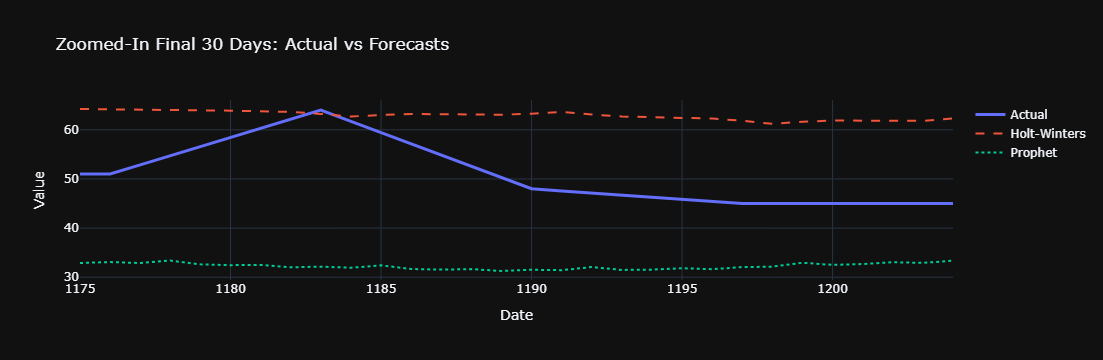

In [113]:
zoom_test = test.iloc[-30:]

fig_zoom = go.Figure()

fig_zoom.add_trace(go.Scatter(
    x=zoom_test.index, y=zoom_test['y'],
    mode='lines', name='Actual', line=dict(width=3)
))

fig_zoom.add_trace(go.Scatter(
    x=zoom_test.index, y=hw_pred[-30:],
    mode='lines', name='Holt-Winters', line=dict(width=2, dash='dash')
))

fig_zoom.add_trace(go.Scatter(
    x=zoom_test.index, y=prophet_pred[-30:],
    mode='lines', name='Prophet', line=dict(width=2, dash='dot')
))

fig_zoom.update_layout(
    title="Zoomed-In Final 30 Days: Actual vs Forecasts",
    xaxis_title="Date", yaxis_title="Value",
    template="plotly_dark", hovermode="x unified"
)

fig_zoom.show()

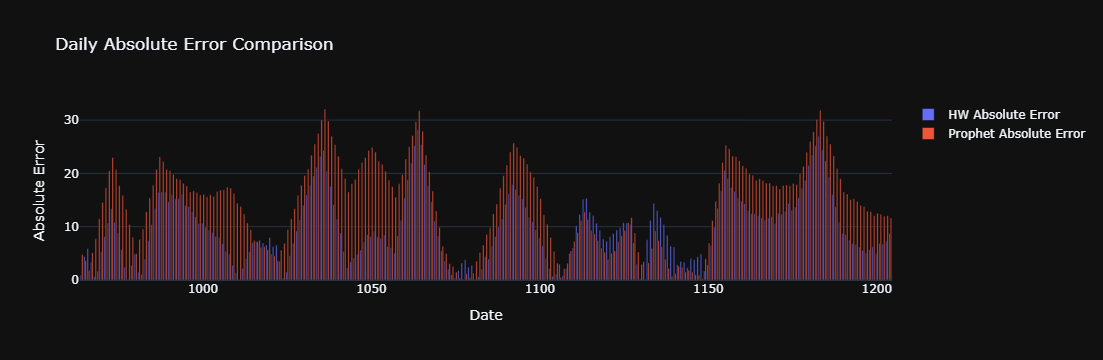

In [135]:
import numpy as np

hw_abs = np.abs(test['y'] - hw_pred)
prophet_abs = np.abs(test['y'] - prophet_pred)

fig_abs = go.Figure()

fig_abs.add_trace(go.Bar(
    x=test.index,
    y=hw_abs,
    name='HW Absolute Error'
))

fig_abs.add_trace(go.Bar(
    x=test.index,
    y=prophet_abs,
    name='Prophet Absolute Error'
))

fig_abs.update_layout(
    title="Daily Absolute Error Comparison",
    xaxis_title="Date",
    yaxis_title="Absolute Error",
    template="plotly_dark",
    barmode='group',
    height=500
)

fig_abs.show()

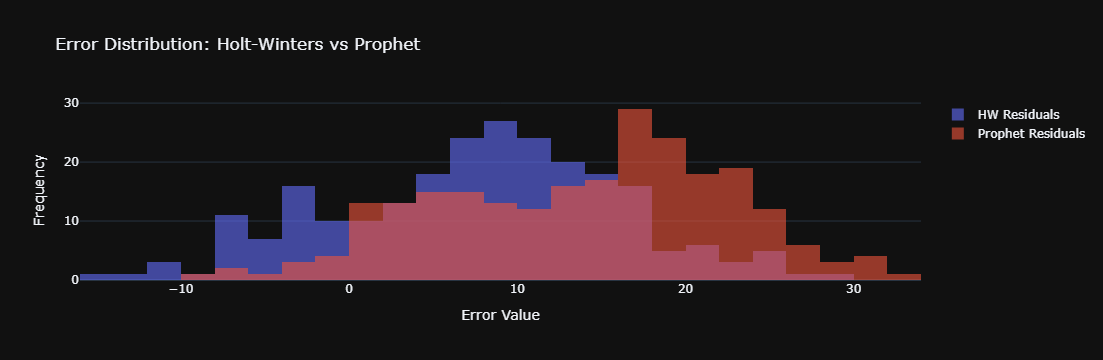

In [143]:
fig_hist = go.Figure()

fig_hist.add_trace(go.Histogram(
    x=hw_residuals,
    name='HW Residuals',
    opacity=0.6
))

fig_hist.add_trace(go.Histogram(
    x=prophet_residuals,
    name='Prophet Residuals',
    opacity=0.6
))

fig_hist.update_layout(
    title="Error Distribution: Holt-Winters vs Prophet",
    xaxis_title="Error Value",
    yaxis_title="Frequency",
    template="plotly_dark",
    barmode='overlay',
    height=500
)

fig_hist.show()

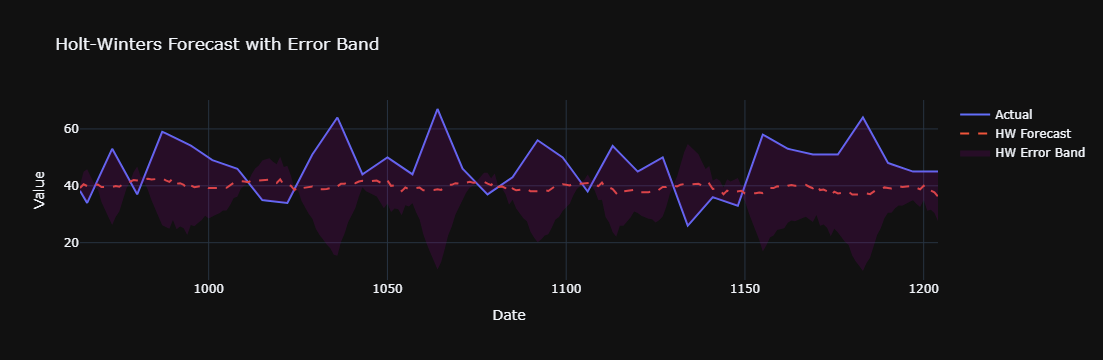

In [145]:
hw_upper = hw_pred + hw_abs
hw_lower = hw_pred - hw_abs

fig_band = go.Figure()

# Actual
fig_band.add_trace(go.Scatter(
    x=test.index, y=test['y'],
    mode='lines', name='Actual',
    line=dict(width=2)
))

# HW Forecast
fig_band.add_trace(go.Scatter(
    x=test.index, y=hw_pred,
    mode='lines', name='HW Forecast',
    line=dict(width=2, dash='dash')
))

# Shaded error band
fig_band.add_trace(go.Scatter(
    x=list(test.index) + list(test.index[::-1]),
    y=list(hw_upper) + list(hw_lower[::-1]),
    fill='toself',
    fillcolor='rgba(128,0,128,0.2)',
    line=dict(color='rgba(255,255,255,0)'),
    name='HW Error Band'
))

fig_band.update_layout(
    title="Holt-Winters Forecast with Error Band",
    xaxis_title="Date",
    yaxis_title="Value",
    template="plotly_dark",
    hovermode='x unified',
    height=500
)

fig_band.show()